# **Auto Encoder(+Noise)**

# **Settings**

In [1]:
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/메타버스 아카데미/Data/')
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

import torch
import torchvision 
import torch.nn.functional as F
from torch import nn, optim
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

# **1. 데이터 불러오기**

In [2]:
# 가우시안 노이즈 추가 함수
def gaussian_noise(x, scale=0.8):
    gaussian_data_x = x + np.random.normal(loc=0, scale=scale, size=x.shape)
    gaussian_data_x = np.clip(gaussian_data_x,0,1)
    gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    
    return gaussian_data_x

In [3]:
train_data = MNIST(root='./metaverse',train=True,download=True,transform=ToTensor())
test_data = MNIST(root='./metaverse',train=False,download=True,transform=ToTensor())

Text(0.5, 1.0, '가우시안 노이즈 추가')

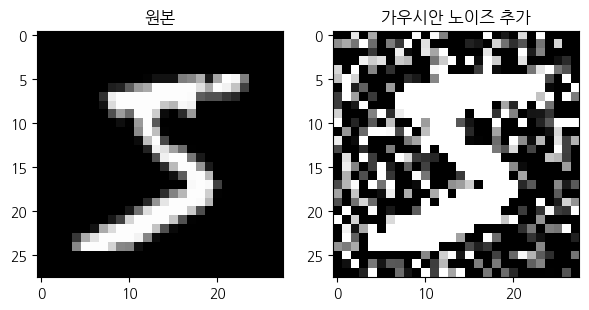

In [4]:
img = train_data.data[0]
img_noise = gaussian_noise(img)

fig, ax = plt.subplots(1,2,figsize=(7,4))
ax[0].imshow(img.numpy(),cmap='gray')
ax[0].set_title('원본')
ax[1].imshow(img_noise.numpy(),cmap='gray')
ax[1].set_title('가우시안 노이즈 추가')

# **2. 데이터 만들기**

In [5]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./metaverse',train=True,download=True,transform=ToTensor())
        
        self.data = []
        for temp in range(len(self.mnist)):
            noise_input = gaussian_noise(self.mnist.data[temp])
            input_tensor = torch.tensor(noise_input)
            self.data.append(torch.unsqueeze(input_tensor,dim=0))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        data = self.data[i]
        label = self.mnist.data[i]/255
        
        return data, label

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **3. 모델 설정**

In [7]:
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_dim):
        super(BasicBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channel,hidden_dim,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(hidden_dim,out_channel,kernel_size=3,padding=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        return x


In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        
        self.conv1 = BasicBlock(in_channel=1,hidden_dim=16,out_channel=16)
        self.conv2 = BasicBlock(in_channel=16,hidden_dim=8,out_channel=8)
        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        return x

In [9]:
from torchsummary import summary

encoder = Encoder().to(device)
summary(encoder, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
        BasicBlock-5           [-1, 16, 28, 28]               0
         AvgPool2d-6           [-1, 16, 14, 14]               0
            Conv2d-7            [-1, 8, 14, 14]           1,160
              ReLU-8            [-1, 8, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             584
             ReLU-10            [-1, 8, 14, 14]               0
       BasicBlock-11            [-1, 8, 14, 14]               0
        AvgPool2d-12              [-1, 8, 7, 7]               0
Total params: 4,224
Trainable params: 4,224
Non-trainable params: 0
-----------------------------------

## ***! Note `nn.ConvTranspose2d`***
* 이미지 복원 계산법 nn.ConvTranspose2d
* (size - 1) * stride - 2*padding + kernel_size

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

        self.upsample1= nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
        self.upsample2= nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        
        return x

In [11]:
decoder = Decoder().to(device)
summary(decoder, input_size=(8,7,7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 7, 7]             584
              ReLU-2              [-1, 8, 7, 7]               0
            Conv2d-3              [-1, 8, 7, 7]             584
              ReLU-4              [-1, 8, 7, 7]               0
        BasicBlock-5              [-1, 8, 7, 7]               0
   ConvTranspose2d-6            [-1, 8, 14, 14]             264
            Conv2d-7           [-1, 16, 14, 14]           1,168
              ReLU-8           [-1, 16, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           2,320
             ReLU-10           [-1, 16, 14, 14]               0
       BasicBlock-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12           [-1, 16, 28, 28]           1,040
           Conv2d-13            [-1, 1, 28, 28]             145
Total params: 6,105
Trainable params: 6

In [12]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.squeeze(x)
    
        return x

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
from torch.utils.data import DataLoader
from torch.optim import Adam

train_data = Denoising()
train_loader = DataLoader(train_data, batch_size=32)

model = Model().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [15]:
from tqdm import tqdm 

epochs = 20

for epoch in range(epochs):
    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        pred = model(data.to(device))
        
        loss = criterion(torch.squeeze(pred),label.to(device))
        loss.backward()
        optimizer.step()
        
    print(f'epoch {epoch+1}  loss {loss.item()}')

100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 161.99it/s]


epoch 1  loss 0.013161206617951393


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 165.03it/s]


epoch 2  loss 0.010907971300184727


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 160.85it/s]


epoch 3  loss 0.009781445376574993


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 149.78it/s]


epoch 4  loss 0.009502368047833443


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 149.04it/s]


epoch 5  loss 0.009510456584393978


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 149.91it/s]


epoch 6  loss 0.009393141604959965


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 151.46it/s]


epoch 7  loss 0.009005752392113209


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 152.69it/s]


epoch 8  loss 0.008093627169728279


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 151.53it/s]


epoch 9  loss 0.007820319384336472


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 151.08it/s]


epoch 10  loss 0.007693931460380554


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 155.05it/s]


epoch 11  loss 0.007457586005330086


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 155.19it/s]


epoch 12  loss 0.00737000210210681


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 159.07it/s]


epoch 13  loss 0.007228498347103596


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 154.62it/s]


epoch 14  loss 0.007211359683424234


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 155.23it/s]


epoch 15  loss 0.0072212242521345615


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 152.05it/s]


epoch 16  loss 0.007156199309974909


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 159.20it/s]


epoch 17  loss 0.007123816758394241


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 161.58it/s]


epoch 18  loss 0.007134990766644478


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:11<00:00, 157.37it/s]


epoch 19  loss 0.0070840222761034966


100%|█████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:12<00:00, 152.21it/s]

epoch 20  loss 0.007070596795529127


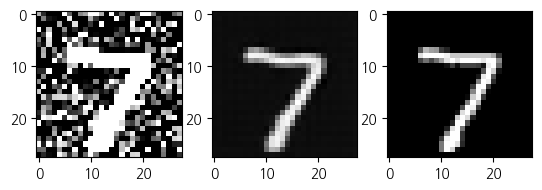

In [18]:
model.cpu()
model.eval()

with torch.no_grad():
    img = test_data.data[0]
    noise = gaussian_noise(img)
    
    input = torch.unsqueeze(noise, dim=0)
    input.type(torch.FloatTensor)
    input.to(device)
    input = torch.unsqueeze(input, dim=0)
    
    plt.subplot(1,3,1)
    plt.imshow(torch.squeeze(noise),cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(torch.squeeze(model(input)),cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(torch.squeeze(img),cmap='gray')